# Setup

## Instructions
1. Download this notebook, and open in it in Jupyer, JupyerLab, VSCode, etc.

In [ ]:
!pip install -U octofitterpy

The first time you import octofitterpy, we will automatically install Julia (via JuliaUp) and compile Octofitter.jl in a self-contained environment. Subsequent imports will be faster.

In [1]:
import octofitterpy as octo

/Users/thompsonw/Documents/octofitterpy
Detected Jupyter notebook. Loading juliacall extension. Set `OCTOFITTERPY_AUTOLOAD_EXTENSIONS=no` to disable.
/Users/thompsonw/Documents/octofitterpy/examples


# Fit Relative Astrometry

We start by defining a likelihood object for our data, in this case relative astrometry of the planet.

In [2]:
astrom_like = octo.PlanetRelAstromLikelihood(
    # MJD
    epoch = [50000,50120,50240,50360,50480,50600,50720,50840],
    # delta RA, milliarcseconds (East is positive)
    ra = [-505.7,-502.5,-498.2,-492.6,-485.9,-478.1,-469.0,-458.8],
    # delta DEC, milliarcseconds (North is positive)
    dec = [-66.9,-37.4,-7.9,21.6,51.1,80.5,109.7,138.6],
    # Uncertainty on RA, milliarcseconds
    σ_ra = [10,10,10,10,10,10,10,10.0],
    # Uncertainty on DEC, milliarcseconds
	σ_dec = [10,10,10,10,10,10,10,10],
    # Corelation between RA and DEC uncertainties
	cor= [0,0,0,0,0,0,0,0.0]
)
astrom_like

PlanetRelAstromLikelihood Table with 6 columns and 8 rows:
     cor  σ_ra  σ_dec  ra      dec    epoch
   ┌───────────────────────────────────────
 1 │ 0.0  10.0  10     -505.7  -66.9  50000
 2 │ 0.0  10.0  10     -502.5  -37.4  50120
 3 │ 0.0  10.0  10     -498.2  -7.9   50240
 4 │ 0.0  10.0  10     -492.6  21.6   50360
 5 │ 0.0  10.0  10     -485.9  51.1   50480
 6 │ 0.0  10.0  10     -478.1  80.5   50600
 7 │ 0.0  10.0  10     -469.0  109.7  50720
 8 │ 0.0  10.0  10     -458.8  138.6  50840

If your dates aren't in MJD format, you might use one of these functions to convert:

**To convert dates:**
*  `octo.mjd("2020-01-01")` -> to MJD
*  `octo.years2mjd("2020.0")` -> to MJD
*  convert back: `octo.mjd2date(50000)` -> `datetime.date(1995, 10, 10)`



You could also define the astrometry using a separation & position angle format:
```python
# You can also use separation (milliarcseconds) and position angle (RADIANS):
astrom_like = octo.PlanetRelAstromLikelihood(
    # MJD
    epoch = [50000,50120],
    # separation from star, milliarcseconds (East is positive)
    sep = [505.7,600.1],
    # position angle, RADIANS (!!) (NOT DEGREES)
    pa = [0.0,0.4,],
    # Uncertainty on sep, milliarcseconds
    σ_sep = [10,10],
    # Uncertainty on pa, RADIANS
	σ_pa = [0.01,0.01],
    # Corelation between PA and SEP uncertainties
    cor= [0,0.2]
)
```

We now define the planet component of our model. We specify a name, an orbital basis, our priors, and list any likelihood objects.

Note! Change the reference epoch provided to `θ_at_epoch_to_tperi` from 50000 to one where your astrometry is defined. This is critical for good performance.

In [3]:
planet_b = octo.Planet(
    name="b",
    basis="Visual{KepOrbit}",
    priors=
    """            
        a ~ LogUniform(0.1, 500)
        e ~ Uniform(0.0, 0.99)
        i ~ Sine()
        ω ~ UniformCircular()
        Ω ~ UniformCircular()
        θ ~ UniformCircular()
        tp = θ_at_epoch_to_tperi(system,b,50000) # use MJD epoch of your data here!!
    """,
    likelihoods=[astrom_like]
)

Now we define our system, containing our planet. We provide it with a name (used to specofy the output file names and plot legends), our priors, a list of lieklihood objects for the system as a whole (eg proper motion anomaly, radial velocity), and a list of companion models.

In [4]:
# The name of your system determines the output file names
sys = octo.System(
    name="HIP100123",
    priors = 
    """
        M ~ truncated(Normal(1.2, 0.1), lower=0)
        plx ~ truncated(Normal(50.0, 0.02), lower=0)
    """,
    likelihoods=[],
    companions=[planet_b]
)

We then compile our model. There are a few options for this function (for example, you can select the autodiff backend), but the defaults are reasonable.

In [5]:
model = octo.LogDensityModel(sys)

We now fit the model. By default this uses a Hamiltonian Monte Carlo sampler with 1000 steps of adaptation (discarded) and 1000 iterations. You can pass eg. `adaptation=5000, iterations=25000` if you would like more points for your plots.

In [13]:
chain = octo.octofit(model)

[ Info: Determining initial positions and metric using pathfinder
[ Info: Sampling, beginning with adaptation phase...
Sampling 100%|███████████████████████████████| Time: 0:00:06
  iterations:                                   2000
  ratio_divergent_transitions:                  0.01
  ratio_divergent_transitions_during_adaption:  0.03
  n_steps:                                      127
  is_accept:                                    true
  acceptance_rate:                              0.8751609825207977
  log_density:                                  -50.070655634064906
  hamiltonian_energy:                           54.065206027415336
  hamiltonian_energy_error:                     -0.05857859572574853
  max_hamiltonian_energy_error:                 0.3105419958132458
  tree_depth:                                   7
  numerical_error:                              false
  step_size:                                    0.016276347960850257
  nom_step_size:                             

Sampling report for chain:
mean_accept                 = 0.9061795447125631
ratio_divergent_transitions = 0.011
mean_tree_depth             = 7.279
max_tree_depth_frac         = 0.0
gradient_evaluations        = 444152


**Long runtimes indiciate an error in your model**

The orbit fitting should take <30 s for this example. If you find it takes much longer on your code, double check the model and priors. Is the epoch you specified for `tperi` the same as your data? 

**Numerical errors indicate a problem with sampling**
If you see a report that numerical errors were encountered during sampling, the results may not be statistically valid. You could re-try sampling, or investigate your model for errors.

We can now display our results

In [14]:
chain

Chains MCMC chain (1000×28×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 7.79 seconds
Compute duration  = 7.79 seconds
parameters        = M, plx, b_a, b_e, b_i, b_ωy, b_ωx, b_Ωy, b_Ωx, b_θy, b_θx, b_ω, b_Ω, b_θ, b_tp
internals         = n_steps, is_accept, acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, is_adapt, loglike, logpost, tree_depth, numerical_error

Summary Statistics
  parameters         mean         std       mcse    ess_bulk   ess_tail      r ⋯
      Symbol      Float64     Float64    Float64     Float64    Float64   Floa ⋯

           M       1.1895      0.0976     0.0046    460.6517   525.3502    1.0 ⋯
         plx      49.9998      0.0195     0.0006   1042.4646   574.8890    0.9 ⋯
         b_a      12.9485      4.4464     0.5346     82.9477    99.6294    1.0 ⋯
         b_e       0.1881      0.1335  

If you wish to save this summary table to a text file, you can convert it to a string like so:

In [15]:
summary_str = repr(chain)

The chain itself can be saved to a FITS table like so:

In [16]:
octo.savechain("mychain.fits", chain)

## Plotting

Display posterior draws as orbits. These functions generate output images in your folder instead of displaying inline in the notebook. 

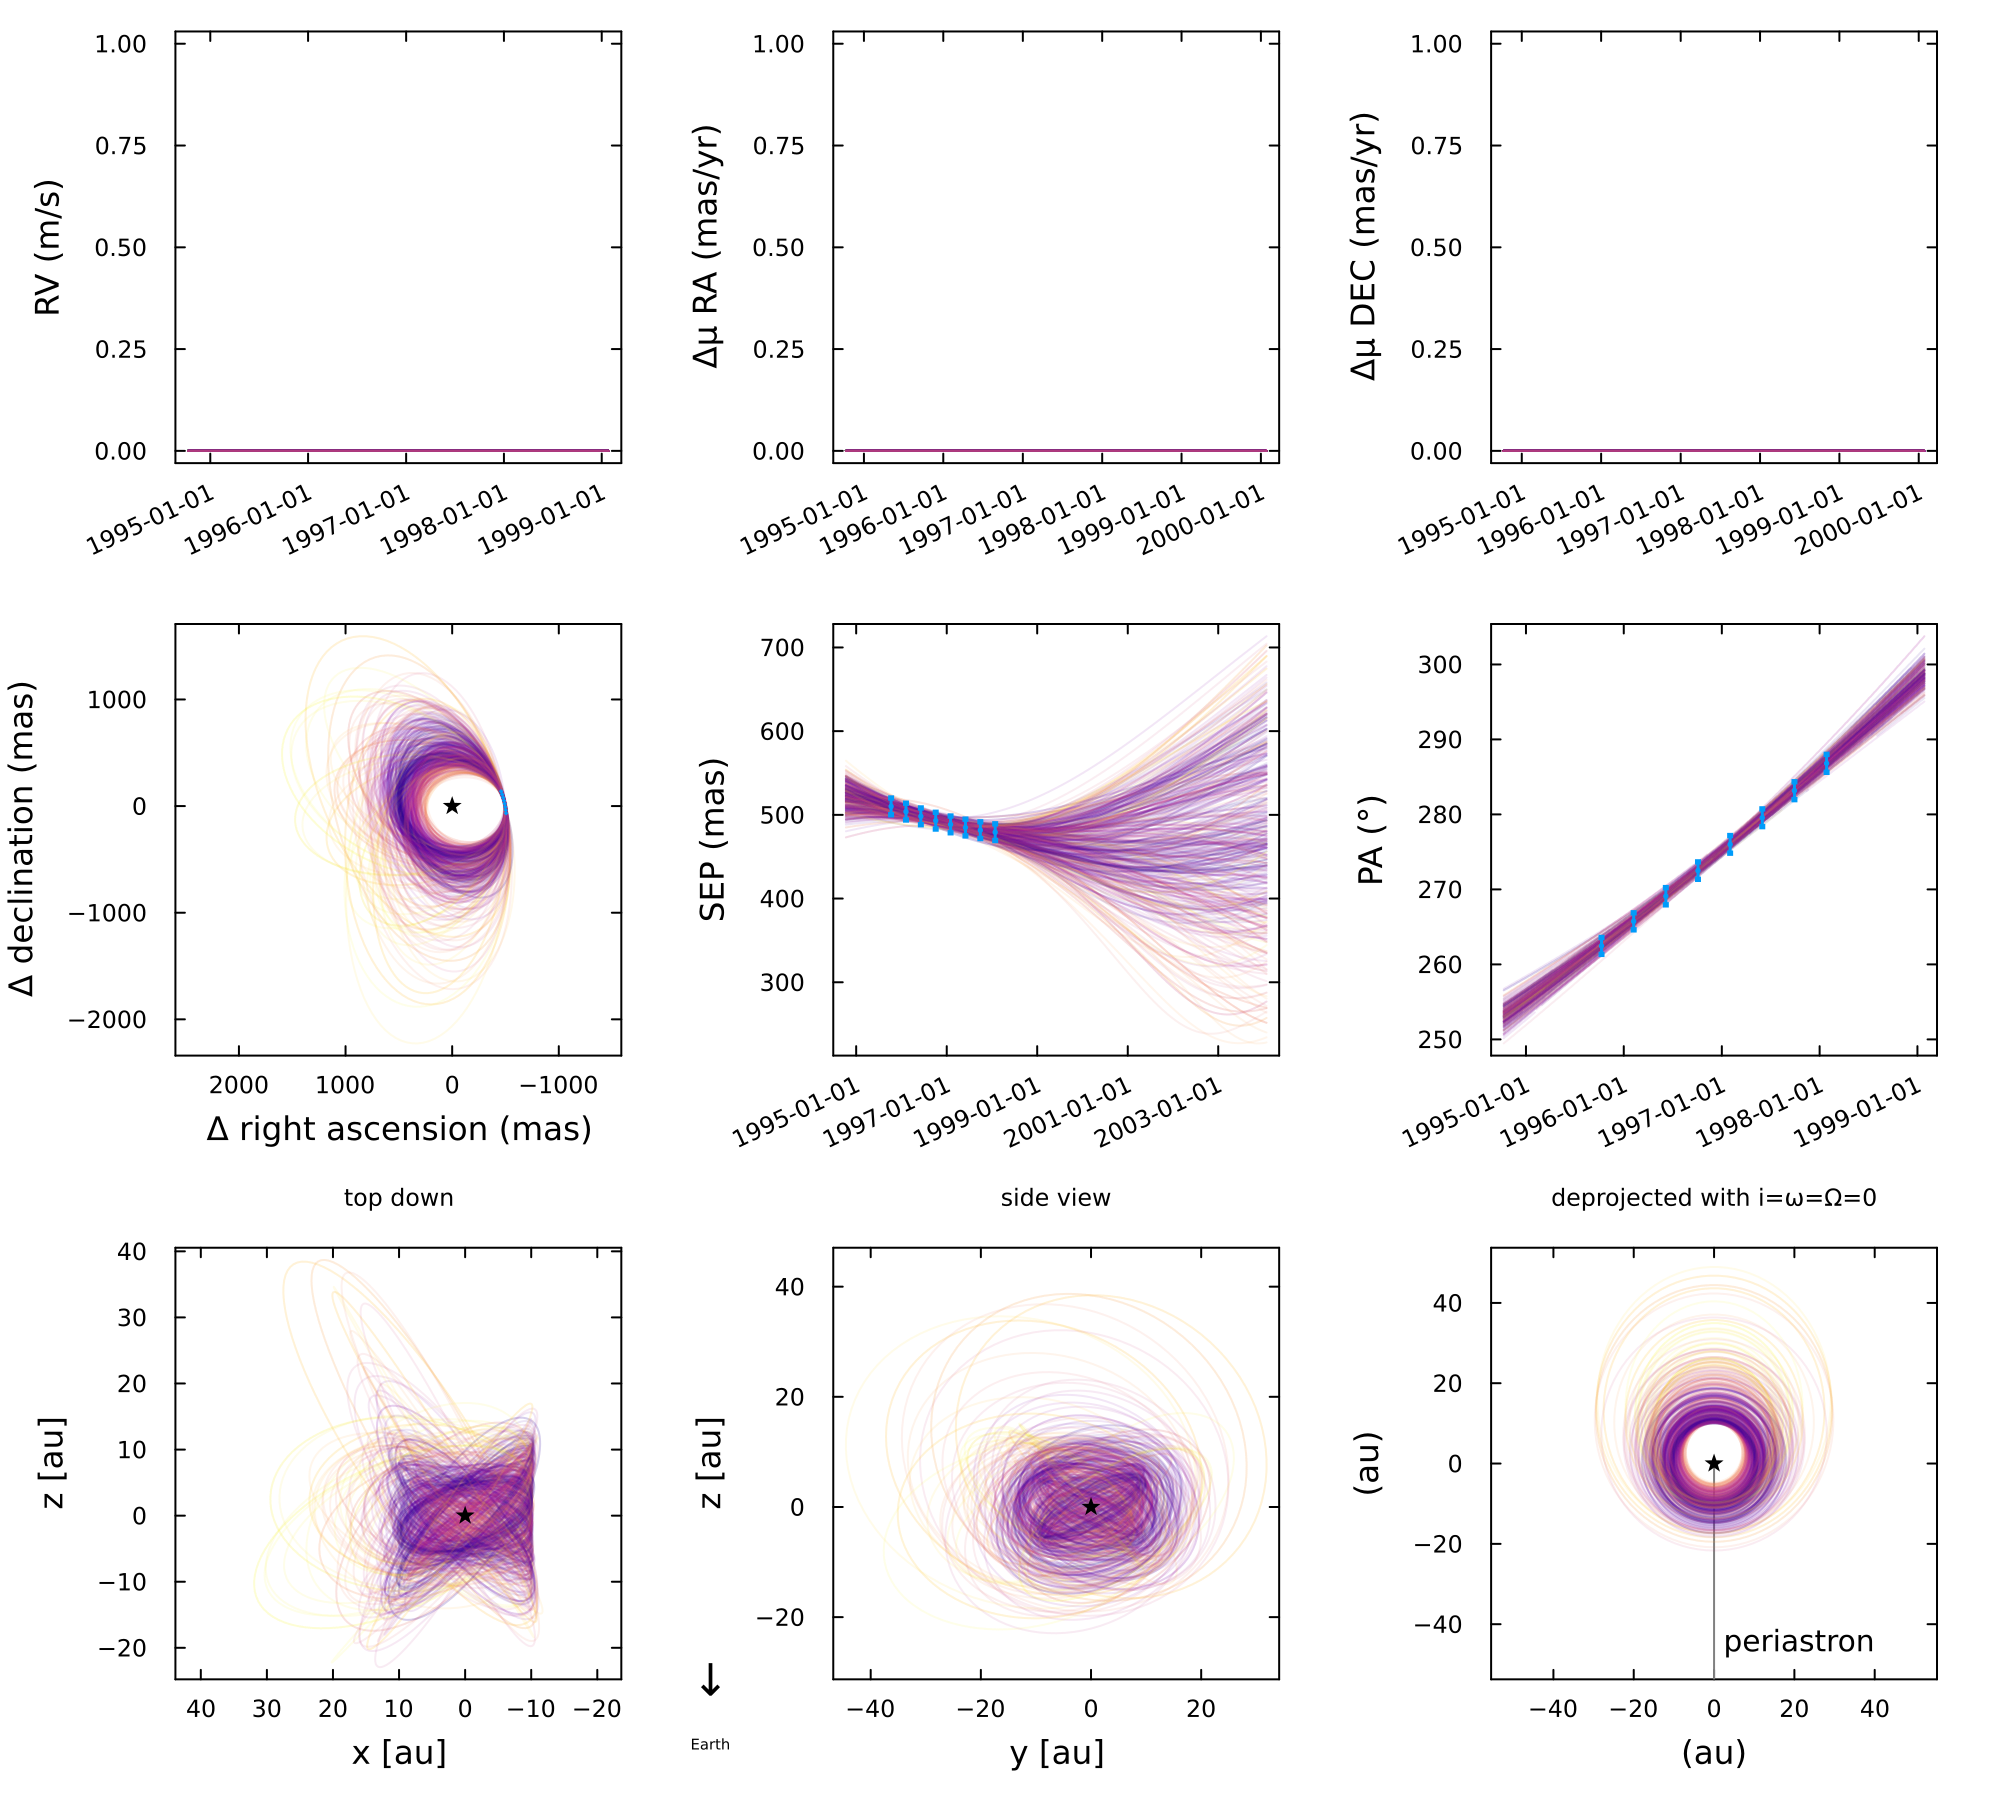

In [17]:
octo.octoplot(model,chain)

Now make a corner plot. Set `small=False` to see all variables.

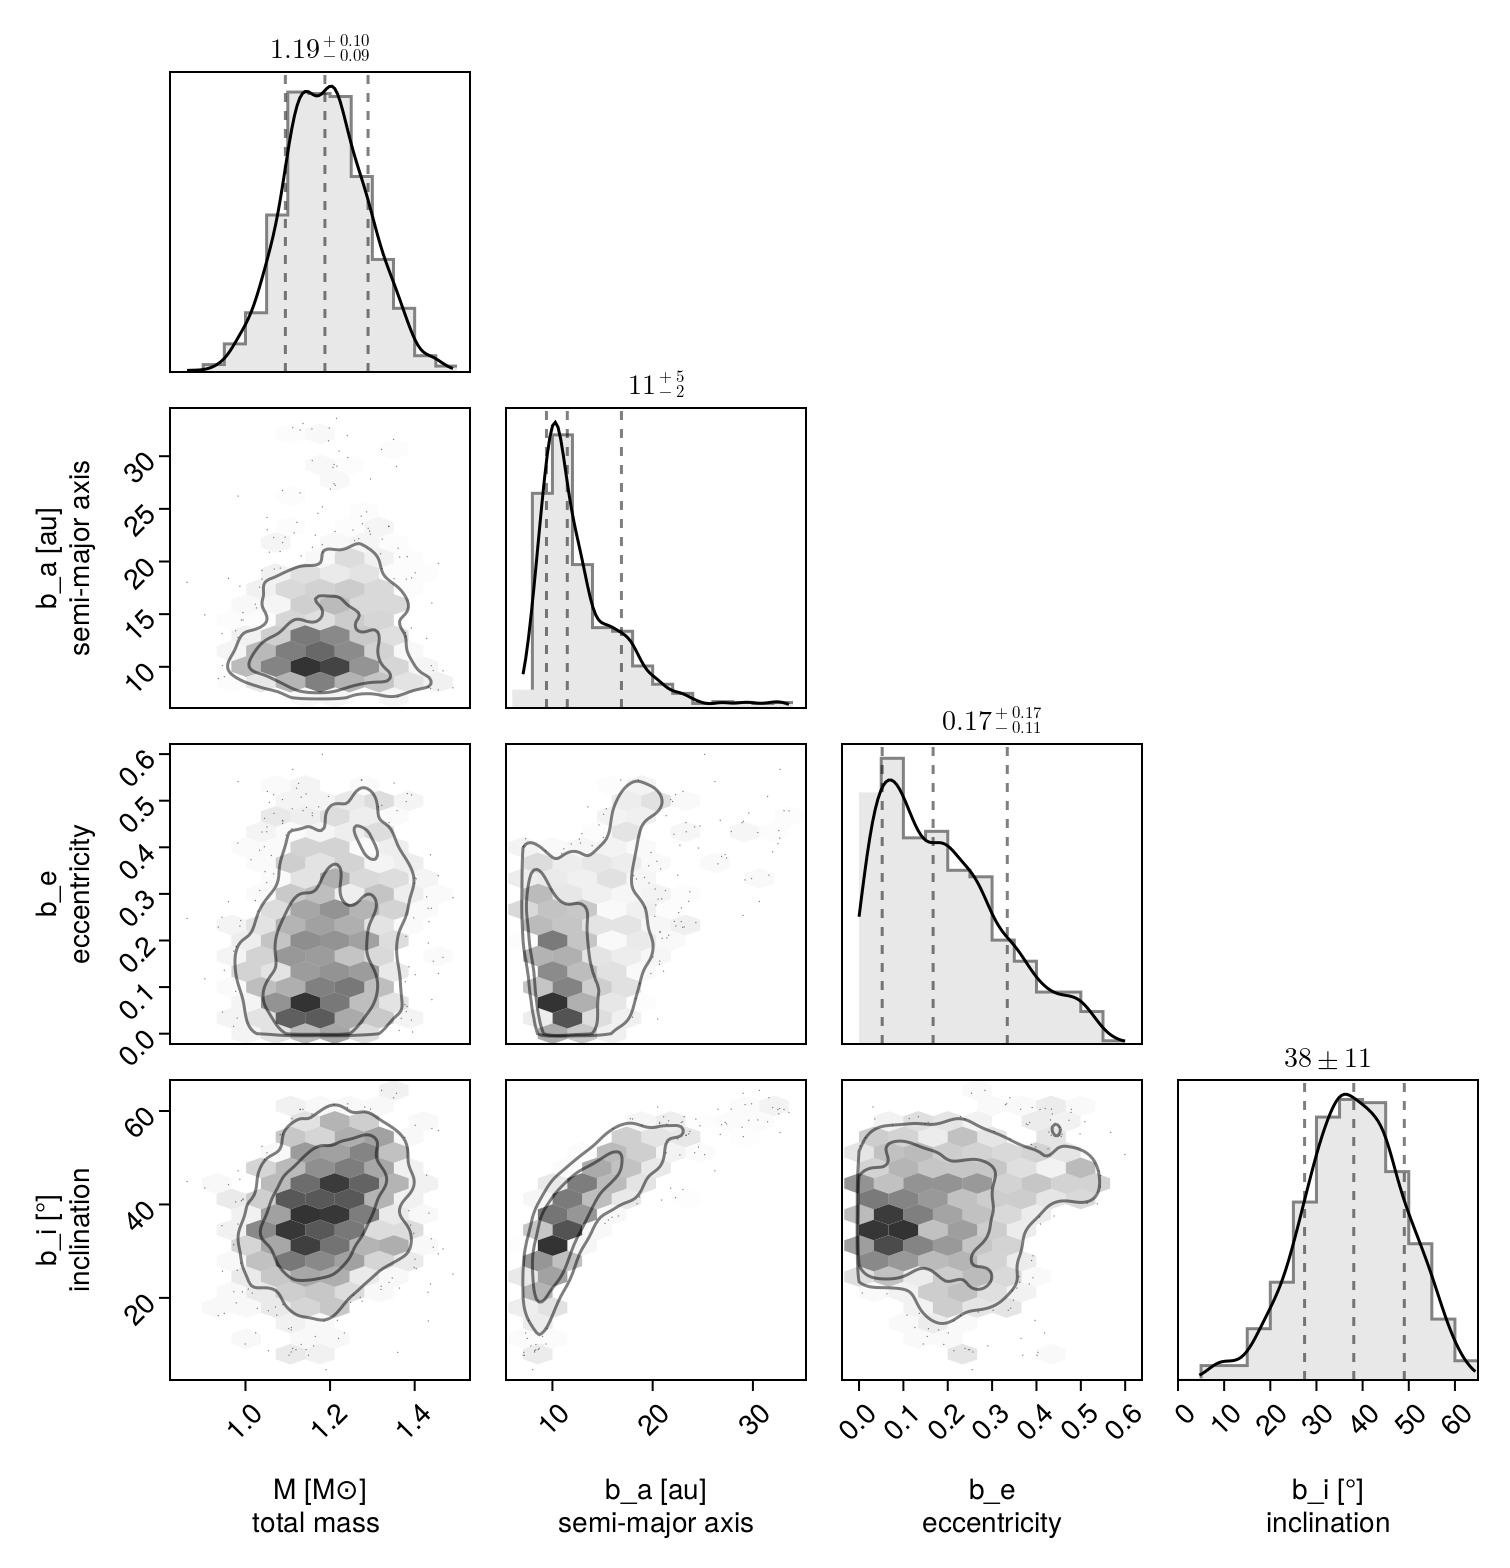

In [18]:
octo.octocorner(model,chain,small=True)